<a href="https://colab.research.google.com/github/nagym72/machine-learning-implementations-with-pytorch/blob/main/Conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
tensor_transforms = transforms.ToTensor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = datasets.MNIST(root = "./data",
                         transform=tensor_transforms, train=True,
                         download=True)

loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=64,
                                     shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Conv_encoder(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.encode_block_1 = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size=(2,2)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size=(2,2)),
        torch.nn.ReLU())
    
    self.encode_block_2 = torch.nn.Sequential(
        #Linear block starts here output here is 12,24,24
        torch.nn.Linear(in_features = 12*26*26, out_features = 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 8)
        )
    
    self.decode_block_1 = torch.nn.Sequential(
        torch.nn.Linear(8, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, out_features = 12*26*26))
    
    self.decode_block_2 = torch.nn.Sequential(
        torch.nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=(2,2)),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=(2,2)),
        torch.nn.Sigmoid()
    )


  def forward(self, x):
    out = self.encode_block_1(x)
    #now we need to flatten the tensor
    out = out.reshape(-1,12*26*26)
    out = self.encode_block_2(out)
    out = self.decode_block_1(out)
    #we need to make a (batchsize, 12, 24,24 tensor again)
    out = out.reshape(-1,12,26,26)
    out = self.decode_block_2(out)
    return out


In [ ]:
model = Conv_encoder().to(device)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [ ]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
  for (image, _) in loader:
    #reshape image to form (Batchsize, 26*26)
    #img = image.reshape(-1, 26*26)
    #push to gpu
    img = image.to(device)
    #make predictions
    predicted = model(img)
    #backtransform to original form
    #evaluate losses
    loss = criterion(predicted, img)

    #set gradients zero, calculate losses, update optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    losses.append(loss.to("cpu"))
    

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, predicted))      

Epoch:1, Loss:0.0216
Epoch:2, Loss:0.0219
Epoch:3, Loss:0.0155
Epoch:4, Loss:0.0174
Epoch:5, Loss:0.0203
Epoch:6, Loss:0.0157
Epoch:7, Loss:0.0166
Epoch:8, Loss:0.0170
Epoch:9, Loss:0.0176
Epoch:10, Loss:0.0157


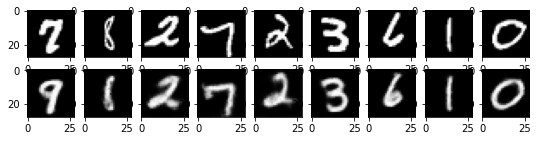

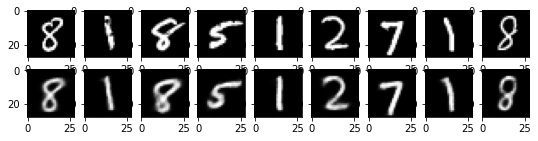

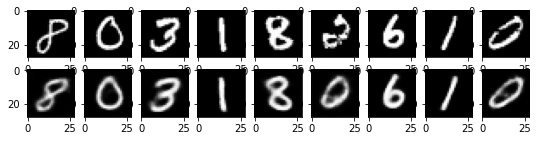

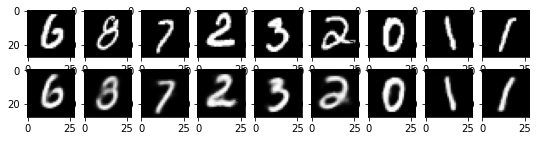

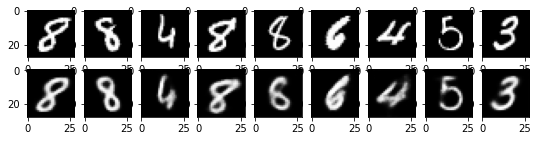

In [ ]:
for k in range(0, epochs, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()
    #take from k epoch the predicted and the original image and convert them back to numpy arrays
    imgs = outputs[k][1].to("cpu").detach().numpy()
    recon = outputs[k][2].to("cpu").detach().numpy()
    #
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])